# Analyzing tweets retweetability by topic

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from empath import Empath
import os.path

Reading dataset

In [2]:
# Reading raw dataset
df = pd.read_csv('./Data/tweets', dtype={'retweetability': 'bool', 'favorite_count': 'int', 'retweet_count': 'int'})
print(f"Raw dataset shape:\t{df.shape}")

# Filtering dataset for english original (not a reply nor a retweet) tweets
in_english = df['lang'] == 'en'
not_a_reply = df['in_reply_to_user_id'].isna()
not_a_retweet = df['retweet_id'].isna()
df = df[in_english & not_a_reply & not_a_retweet].drop_duplicates(subset=['text'], keep=False)
print(f"Filtered dataset shape:\t{df.shape}")

# Retweetability column
df['retweetability'] = df['retweet_count'] > 0

# Showing dataset
print(f"\nHEAD of filtered dataset:\n")
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Raw dataset shape:	(1609389, 34)
Filtered dataset shape:	(639819, 34)

HEAD of filtered dataset:



,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,retweetability
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,False
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,False
8,NaN,Sun Feb 14 18:46:26 +0000 2010,NaN,NaN,NaN,0,9107804301,NaN,NaN,NaN,...,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,False
9,NaN,Fri Sep 28 19:07:04 +0000 2012,NaN,NaN,http://twitcam.livestream.com/c7fe0,0,251759950655791105,NaN,NaN,NaN,...,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,False
11,NaN,Fri Sep 28 19:05:53 +0000 2012,NaN,NaN,http://twitcam.livestream.com/c7fe0,0,251759653464199168,NaN,NaN,NaN,...,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,False


## Topic extraction

**Empath lexicon**

We are going to use [*Empath*](https://github.com/Ejhfast/empath-client), a tool for analyzing text across lexical categories. It will be used to extract tweets that can be related to a certain topic.

In [3]:
lexicon = Empath()

We show an example of usage for two different sentences

In [4]:
example_1 = "We love playing basketball"
example_2 = "We love playing the guitar"
for ex in [example_1, example_2]:
    print(f"Sentence:\t{ex}")
    print(f"Result:\t\t{lexicon.analyze(ex, categories = ['sports', 'music'])}")
    print(f"Normalized result:\t{lexicon.analyze(ex, categories = ['sports', 'music'], normalize = True)}\n")
    
print("Explanation: 'playing' and 'basketball' are in the sports keyword set,"
      " whereas 'guitar' falls into the music keywords set.")

Sentence:	We love playing basketball
Result:		{'sports': 2.0, 'music': 0.0}
Normalized result:	{'sports': 0.5, 'music': 0.0}

Sentence:	We love playing the guitar
Result:		{'sports': 1.0, 'music': 1.0}
Normalized result:	{'sports': 0.2, 'music': 0.2}

Explanation: 'playing' and 'basketball' are in the sports keyword set, whereas 'guitar' falls into the music keywords set.


**Lexical Categories**

In [5]:
categories = list(lexicon.cats.keys())
categories.sort()
print(f"There are {len(categories)} predefined categories.\nSome of the categories are: {categories[:20] + ['...']}")
print(f"\nEach category contains a set of keywords:\nsports: {lexicon.cats['sports'][:20] + ['...']}")

There are 194 predefined categories.
Some of the categories are: ['achievement', 'affection', 'aggression', 'air_travel', 'alcohol', 'ancient', 'anger', 'animal', 'anonymity', 'anticipation', 'appearance', 'art', 'attractive', 'banking', 'beach', 'beauty', 'blue_collar_job', 'body', 'breaking', 'business', '...']

Each category contains a set of keywords:
sports: ['kickoff', 'gymnasium', 'gym', 'pitching', 'competition', 'volley', 'fanatic', 'halftime', 'skiing', 'basketball', 'touchdown', 'trampoline', 'coaching', 'backstroke', 'varsity', 'track', 'gymnastics', 'court', 'skateboarding', 'playoff', '...']


We will select 8 of these categories:<br>*sports, politics, music, religion, health, cooking, fashion, and family*

In [6]:
CATEGORIES = ["sports", "politics", "music", "religion", "health", "cooking", "fashion", "family"]

**Computing topic extraction**

Let's compute the category scores for each tweet, and then select the most probable category if any detected. Or load the already computed dataset (saving time).

In [7]:
categorized_dataset = 'Data/categorized_tweets.csv'
load_df = False

if not os.path.isfile(categorized_dataset) or not load_df:
    
    def score_categories(x, cats=CATEGORIES):
        cat_scores = lexicon.analyze(x.text, categories = cats)
        return [int(x) for x in list(cat_scores.values())]

    df_cats = df.apply(score_categories, axis=1)
    df_cats = pd.DataFrame(df_cats.to_list(), index=df_cats.index, columns=CATEGORIES)
    df = df.join(df_cats)

    # Extracting the category with the maximum number of occurrences
    def max_category(x, cats=CATEGORIES):
        array = [x[cat] for cat in cats]
        if np.sum(array) == 0:
            res = np.nan
        elif array.count(max(array)) > 1:
            res = np.nan
        else:
            res = cats[np.argmax(array)]
        return res

    df['category'] = df[CATEGORIES].apply(max_category, axis=1)
    
    # Write dataset
    df.to_csv(categorized_dataset, index=False)
    
# Read already created dataset
elif os.path.isfile(categorized_dataset) and 'category' not in df.columns and load_df:
    df = pd.read_csv(categorized_dataset)

For each category, we have counted the number of keywords present in the text. Then, the category with more keywords is considered the actual category of the tweet.

In [8]:
print(f"{df['category'].isna().value_counts()[False]} tweets were categorized;"
      f" {df['category'].isna().value_counts()[False]/len(df)*100:.2f}% of the total {len(df)} tweets.")

78194 tweets were categorized; 12.22% of the total 639819 tweets.


Categorized tweets keyword count:

In [9]:
df[df.columns[-(len(CATEGORIES)+1):]][~df['category'].isna()].sample(n=4, random_state=0)

,sports,politics,music,religion,health,cooking,fashion,family,category
156741,0,0,0,0,0,0,1,0,fashion
1408686,0,0,0,0,0,0,0,1,family
515334,0,0,0,0,0,0,0,1,family
1315816,1,0,0,0,0,0,0,0,sports


## Tweets per category

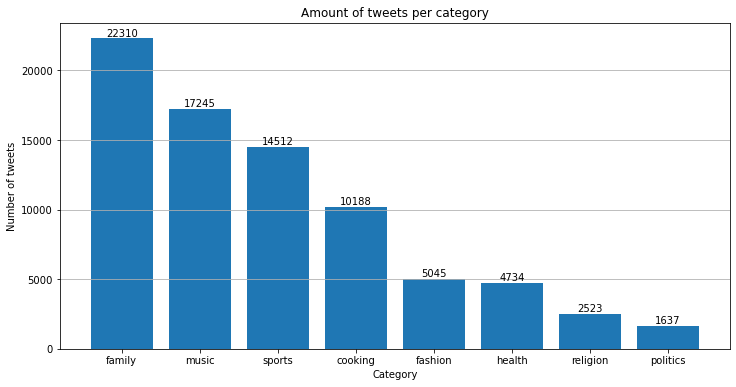

In [10]:
counts_series = df['category'].value_counts()

plt.figure(figsize=(12,6))
ax = plt.bar(counts_series.index, counts_series.values)
plt.grid(axis='y')
plt.title('Amount of tweets per category')
plt.ylabel('Number of tweets')
plt.xlabel('Category')

# Showing labels
for rect, label in zip(ax.patches, counts_series.values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

## Group statistics

In [11]:
group_stats =   (df[['category', 'text', 'retweet_count', 'favorite_count', 'retweetability']]
                 .groupby('category')
                 .agg({'text':'count', 'retweet_count':['mean', 'std'], 'retweetability':'mean', 'favorite_count':['mean', 'std']})
                 .sort_values(('retweet_count', 'mean'), ascending=False)
                )

In [12]:
def highlight_max(data): #, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold'
    #attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [13]:
group_stats.style.apply(highlight_max, axis=0)# % 'bold')

## Showing some of the tweets

In [14]:
def sample_tweets(cat, N=10, seed=None, min_rt=0):
    df_w = (df[(df['category']==cat) & (df['retweet_count'] > min_rt)]
            [['retweet_count', 'favorite_count', 'text', 'user_name']]
           )
    for rt, fav, tweet, user in df_w.sample(n=min(N, len(df_w)), random_state=None).values:
        print(f"RTs: {str(rt).ljust(4)}\tFavs: {str(fav).ljust(4)}\tUser: {user.ljust(15)} Tweet: {tweet}")

In [20]:
sample_tweets('religion', min_rt=10)

RTs: 41  	Favs: 33  	User: Grace + Grit    Tweet: Y'all worship Beyonce but won't worship God
RTs: 12  	Favs: 7   	User: Grace + Grit    Tweet: No sin is worth going to hell for
RTs: 55  	Favs: 29  	User: Carl Sagan      Tweet: "For a long time the human instinct to understand was thwarted by facile religious explanations."
RTs: 21  	Favs: 13  	User: SEBTS           Tweet: If you are able to attend church but do not, then you are living in sin. @MarkDever #9MarksSE
RTs: 27  	Favs: 1   	User: sagittarius's   Tweet: many others are far below us.. come to pray and give thanks!! #SAGITARIUS
RTs: 12  	Favs: 3   	User: ▲ ada aku kesah ▲ Tweet: I'm sorry Palestina. I'm here watching your bloods flow, tears drop, broken hearts thru pictures/news. All I can do is pray for u I'm sorry
RTs: 18  	Favs: 5   	User: Cherry Deeky    Tweet: I'm a FIRM believer in Karma. What you do to someone will come back and attack you 500 times worse. Be careful how you treat people.
RTs: 15  	Favs: 9   	User: SEBT

> Pre-processing to remove repeated tweets. Cameron? Consistency with the other parts of the project

## Statistical Evaluation

We look at the statistics of `retweet_count`and `favorite_count`:
1. **mean value** with its bootstrap confidence intervals.
2. **Expected log value** with its bootstrap confidence intervals too.

The second statistic is related to the fact that the distributions are similar to the power law distribution, and the expected log value is a sufficient statistic for the power law (Idea from [stats.stackexchange](https://stats.stackexchange.com/questions/121925/intuitive-descriptive-statistics-for-power-law-distributions)).

In [16]:
def bootstrap_stat_ci(array, statistic, repetitions=10000, alpha=0.05, resampling_size=None):
    if resampling_size is None:
        resampling_size = int(len(array))
    
    # For reproducibility
    np.random.seed(seed=0)
    
    bootstrap_distribution = []
    for i in range(repetitions):
        # resampled data
        bootstrap_sample = np.random.choice(array, size=resampling_size, replace=True)
        # computing the mean
        stat_sample = statistic(bootstrap_sample)
        # saving the statistic into the bootstrap distribution
        bootstrap_distribution.append(stat_sample)

    # Computing the bootstrap confidence interval
    mean = np.mean(bootstrap_distribution)
    left = np.percentile(bootstrap_distribution, alpha/2*100)
    right = np.percentile(bootstrap_distribution, (1-alpha/2)*100)
    
    return bootstrap_distribution, mean, (left, right)

def compute_statistic(statistic, categories, feature='retweet_count'):
    # Choosing statistic
    if statistic == 'mean':
        stat_func = lambda x: np.mean(x)
    elif statistic == 'mean_log':
        stat_func = lambda x: np.mean(np.log10(x))
    
    # Computing bootstrap ci per category
    x, l_err, r_err = [], [], []
    for cat in categories:
        values = df[df['category']==cat][feature][df[feature]>0].values
        _, mean, (l_ci, r_ci) = bootstrap_stat_ci(values, statistic=stat_func)
        x.append(mean)
        l_err.append(mean-l_ci)
        r_err.append(r_ci-mean)
    err = [l_err, r_err]
    return x, err

def plot_error_bar(x, err, categories, statistic_name=''):
    y = np.linspace(1, 2*len(x)-1, len(x))
    plt.figure(figsize=(10,5))
    plt.errorbar(x, y, xerr=err, fmt = 'o', color = 'k')
    plt.yticks(tuple([0] + list(y) + [y[-1]+1]), tuple([''] + categories + ['']))
    plt.title(statistic_name + ' per Category')
    plt.ylabel('Categories')
    plt.xlabel(statistic_name)
    plt.show()
    
def show(statistic, feature, categories):
    x, err = compute_statistic(statistic, categories, feature)
    plot_error_bar(x, err, categories, statistic_name=' '.join([x.replace('_', ' ').title() for x in [statistic, feature]]))

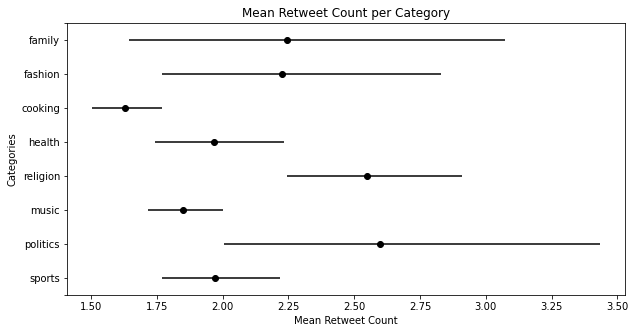

In [17]:
show('mean', 'retweet_count', CATEGORIES)

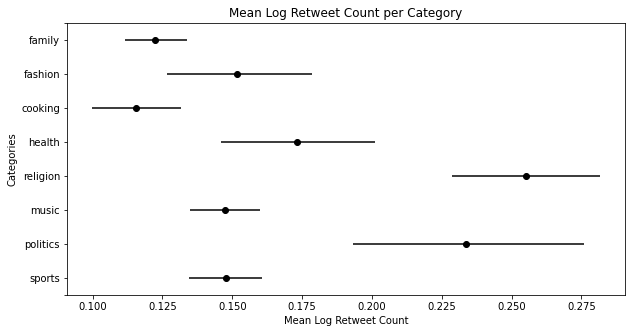

In [18]:
show('mean_log', 'retweet_count', CATEGORIES)

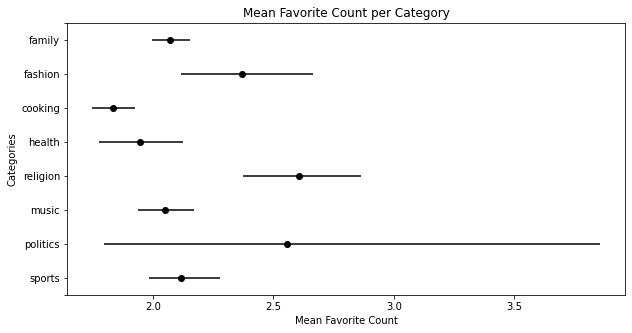

In [19]:
show('mean', 'favorite_count', CATEGORIES)

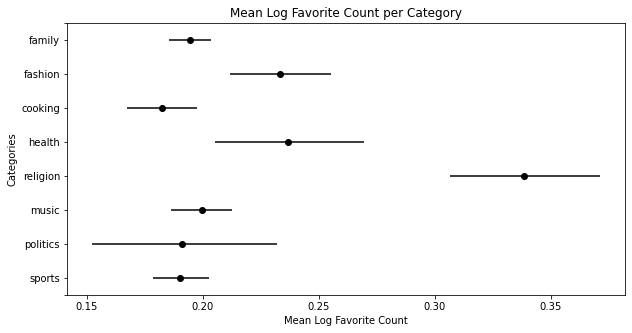

In [26]:
show('mean_log', 'favorite_count', CATEGORIES)

---------------
# EXTRA CODE

## Plotting retweet and favorite distributions

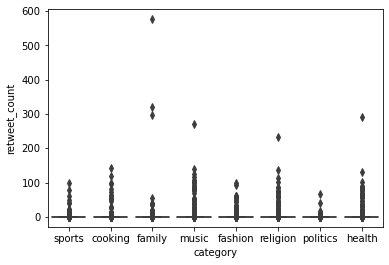

In [13]:
ax = sns.boxplot(x="category", y="retweet_count", data=df)

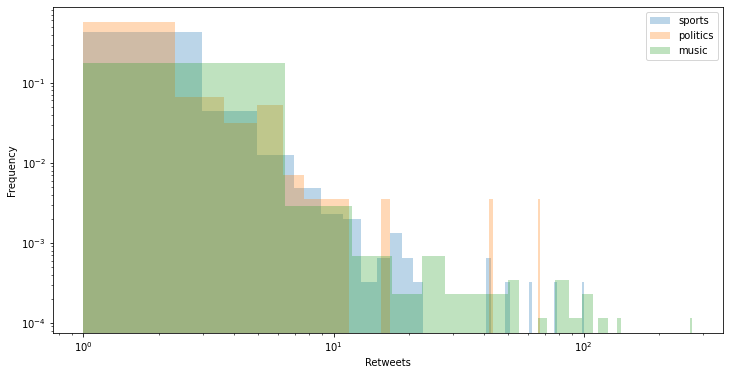

In [21]:
categories = CATEGORIES[:3]

plt.figure(figsize=(12,6))
for cat in categories:
    plt.hist(df[df['category']==cat]['retweet_count'][df['retweet_count']>0].values, bins=50, alpha=0.3, density=True)
plt.legend(categories)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Retweets')
plt.ylabel('Frequency')
plt.show()

**Fitting a power law**

Its pdf is \\( f(x,a) = ax^{a-1} \\)

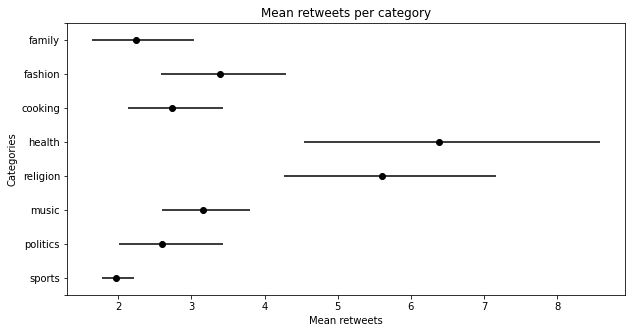

In [76]:
plot_error_bar(x, err, statistic_name='Mean retweets')

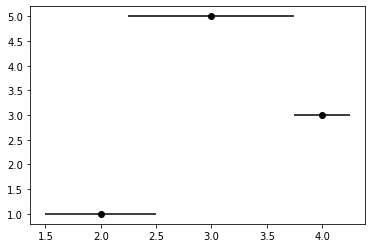

In [64]:
x = [2, 4, 3]
y = np.linspace(1, 2*len(x)-1, len(x))
errors = [0.5, 0.25, 0.75]

plt.figure()
plt.errorbar(x, y, xerr=errors, fmt = 'o', color = 'k')
#plt.yticks((0, 1, 3, 5, 6), ('', 'x3', 'x2', 'x1',''))
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1309f04c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1309f0b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1309f0160>],
 'medians': [<matplotlib.lines.Line2D at 0x1309f2280>],
 'fliers': [<matplotlib.lines.Line2D at 0x1309f2580>],
 'means': []}

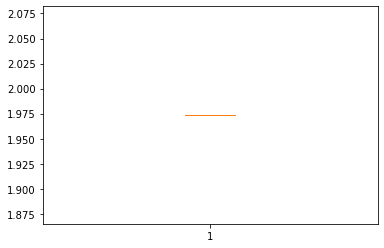

In [47]:
plt.boxplot(mean, conf_intervals=[[l_ci, r_ci])

{'whiskers': [<matplotlib.lines.Line2D at 0x13bb46b80>,
 'caps': [<matplotlib.lines.Line2D at 0x137feb2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13bb46820>],
 'medians': [<matplotlib.lines.Line2D at 0x137feb9a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x137febca0>],
 'means': []}

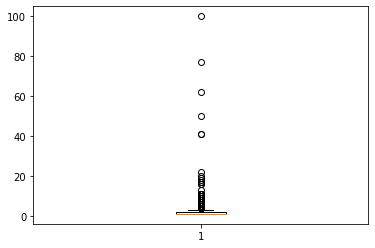

In [42]:
plt.boxplot(rt_sports, bootstrap=10000)

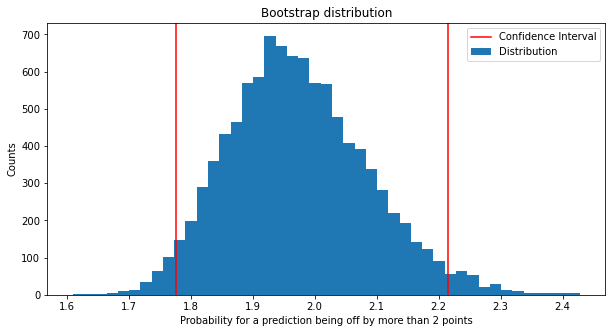

In [61]:
# Plotting the bootstrap distribution

plt.figure(figsize=(10,5))
plt.hist(bootstrap_distribution, bins=45)
plt.title('Bootstrap distribution')
plt.ylabel('Counts')
plt.xlabel('Probability for a prediction being off by more than 2 points')
plt.axvline(x=left, color='red')
plt.legend(['Confidence Interval', 'Distribution'])
plt.axvline(x=right, color='red')
plt.show()

In [26]:
scipy.stats.powerlaw.fit(rt_sports)

(0.20062570982506292, 0.9999999999999998, 107.3392646686593)

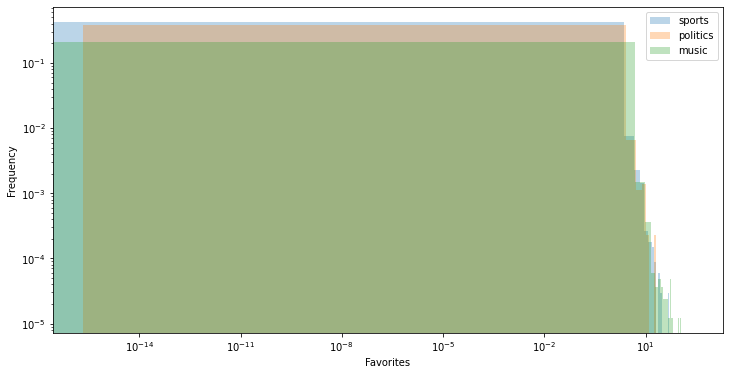

In [20]:
categories = CATEGORIES

plt.figure(figsize=(12,6))
for cat in categories:
    plt.hist(df[df['category']==cat]['favorite_count'].values, bins=50, alpha=0.3, density=True)
plt.legend(categories)
plt.yscale('log')
plt.xlabel('Favorites')
plt.ylabel('Frequency')
plt.show()

# Ideas
- fitting exponentials and plotting lines

-----------
# EXTRA CODE

In [4]:
df[['user_verified', 'retweet_count', 'favorite_count', 'user_followers_count', 'user_friends_count', 'possibly_sensitive']].groupby('user_verified').mean()

,retweet_count,favorite_count,user_followers_count,user_friends_count
user_verified,,,,
False,435.566874,0.203092,1009.317117,556.171973
True,48.289281,0.236034,2406.748778,548.869239


`Time zone` is useless

In [5]:
df['user_time_zone'].value_counts(dropna=False)

NaN    1093122
Name: user_time_zone, dtype: int64

Retweets are the ones without NaN values in `retweet_id`

In [6]:
df['retweet_id'].value_counts(dropna=False)

NaN             918368
4.403222e+17        39
4.862558e+17         6
4.412701e+17         5
4.630483e+17         5
                 ...  
4.456096e+17         1
3.375582e+17         1
4.097441e+17         1
5.210981e+17         1
5.170017e+17         1
Name: retweet_id, Length: 173495, dtype: int64

In [7]:
df[df['retweet_id'].replace(np.nan, False).astype('bool')]['text']

129        RT @GabSoLicious07: @lennymacdog um,  and you ...
180              RT @IAmEricVincent: Hardens gotta get going
223        RT @IAmEricVincent: Glover Quin knocking out e...
244        RT @IAmEricVincent: New look in the @Channel95...
246        RT @SuccessAndBlack: You better check yourself...
                                 ...                        
1608855    RT @justinbieber: check out my new video for #...
1608857              RT @BorisLaursen: RT for a follow! :) x
1609266    RT @naija_sugarmomz: : , For rich Sugar moms a...
1609319    RT @raee_henriquez: Watching the town, then na...
1609385    RT @_mariangelsofia: Hi lovely 💕 @Real_Liam_Pa...
Name: text, Length: 174754, dtype: object

In [8]:
df[df['in_reply_to_status_id'].replace(np.nan, False).astype('bool')]['text']

1228          @kd2578 makes the block AND the dunk? #sctop10
1229                @DeionGottaSTFU @ItsHumbleRob damn...lol
1232       will be me #oneday RT“@digg: This man built hi...
1233       RIP he's the man “@MLive: Report: Detroit's 'E...
1235                             @MBannigan stupid adulthood
                                 ...                        
1609295                              @BorisLaursen pleeeaase
1609333                        @BorisLaursen please boris?!!
1609339                              @icoolselly follow back
1609354                              @BorisLaursen pleaseeee
1609368    @ConnorMalachiim Anna has tweezers from the sc...
Name: text, Length: 189833, dtype: object

Hashtags

In [9]:
kk = df[df['hashtags'].isna() & df.apply(lambda x: '#' in x.text, axis=1)]

df = df.astype({'retweetability': 'bool', 'favorite_count': 'float64'})
df.dropna(axis=0, subset=['category', 'text', 'retweet_count', 'retweetability', 'favorite_count'], inplace=True)
df[['category', 'text', 'retweet_count', 'retweetability', 'favorite_count']].info()

## WONDERS
- Time of the day depends on time zone?
- Cleaning repeated tweets??

TODO:
- Model to predict retweetability (boolean) given a set of features
    - features: num of followers, etc
    - features: same as before + sentiment